## Diamond prices

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from module import *  # in-house module

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## load main dataset
df = sns.load_dataset('diamonds')
df = df[['price','carat','color','cut','clarity']]
cv_errors = pd.DataFrame()  # used to store errors for plotting
tt_errors = pd.DataFrame()  # ^^


def get_errors(data, model, exog, endog, kfold=None):
    if not kfold:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1996)

    cv_errors = pd.DataFrame()
    tt_errors = pd.DataFrame()

    data, test_data = tt_tr_split(data)

    # yield cv errors
    for tr, tt in kfold.split(data):
        xtr, ytr = data.iloc[tr][exog], data.iloc[tr][endog]
        xtt, ytt = data.iloc[tt][exog], data.iloc[tt][endog]
        model.fit(xtr, ytr)

        cv_errors = cv_errors.append((model.predict(xtt) - ytt)**2, ignore_index=True)

    # yield test errors
    tt_errors = tt_errors.append((model.predict(test_data[exog]) - test_data[endog])**2, ignore_index=True)

    return cv_errors, tt_errors

In [13]:
## Basic regression: price ~ b1*carat + e

y = ['price']
X = ['carat']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=False))
])

cross_validate(data=df, endog=y, exog=X, model=pipe)

Cross-validation results: mse = 3726592.62, stdev_err = 8274079.05


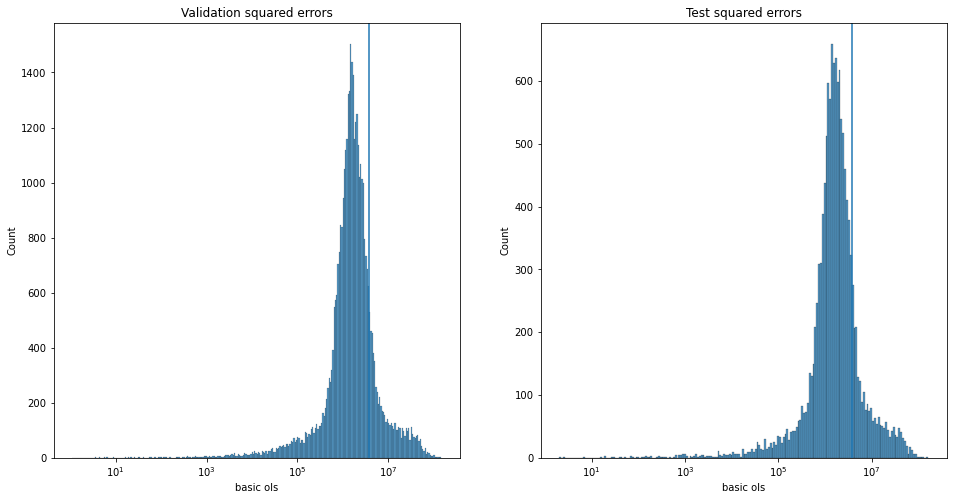

In [14]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['basic ols'], tt_errors['basic ols'] = get_errors(df, pipe, X, y)
sns.histplot(cv_errors['basic ols'], log_scale=True, ax=ax[0]).set_title('Validation squared errors')
ax[0].axvline(x=cv_errors['basic ols'].mean(), c='C0')
sns.histplot(tt_errors['basic ols'], log_scale=True, ax=ax[1]).set_title('Test squared errors')
ax[1].axvline(x=tt_errors['basic ols'].mean(), c='C0')

In [15]:
## Allow prices to be quadratic in carats: price ~ b0 + b1*carat * b2*carat^2 + e

df['carat^2'] = df.carat**2

y = ['price']
X = ['carat','carat^2']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=True))
])

cross_validate(data=df, endog=y, exog=X, model=pipe)

Cross-validation results: mse = 2376727.94, stdev_err = 9200981.35


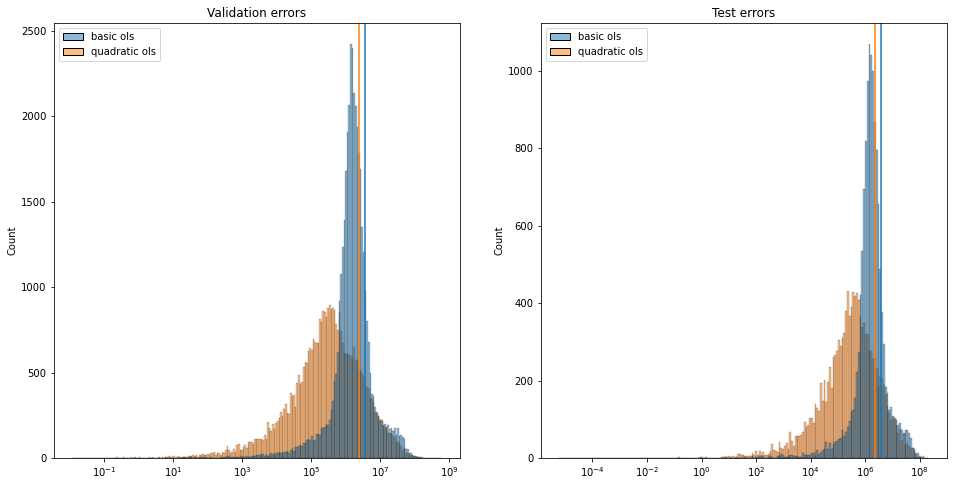

In [16]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['quadratic ols'], tt_errors['quadratic ols'] = get_errors(df, pipe, X, y)
sns.histplot(cv_errors, log_scale=True, ax=ax[0]).set_title('Validation errors')
sns.histplot(tt_errors, log_scale=True, ax=ax[1]).set_title('Test errors')

for pos, col in enumerate(cv_errors.columns):
    ax[0].axvline(x=cv_errors[col].mean(), c=f'C{pos}')

for pos, col in enumerate(tt_errors.columns):
    ax[1].axvline(x=tt_errors[col].mean(), c=f'C{pos}')

In [23]:
## Regression with dummies for categories: price ~ b0 + b1*carat + b2*carat^2 + b3*VVS1 + ... + e

df_dummies = df.drop(['cut','color','clarity'], axis='columns')\
    .join(pd.get_dummies(df.cut, drop_first=True))\
    .join(pd.get_dummies(df.color, drop_first=True))\
    .join(pd.get_dummies(df.clarity, drop_first=True))

y = ['price']
X = [col for col in df_dummies.columns if col != y[0]]

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=True))
])

cross_validate(data=df_dummies, endog=y, exog=X, model=pipe)

Cross-validation results: mse = 1326646.5, stdev_err = 5698042.27


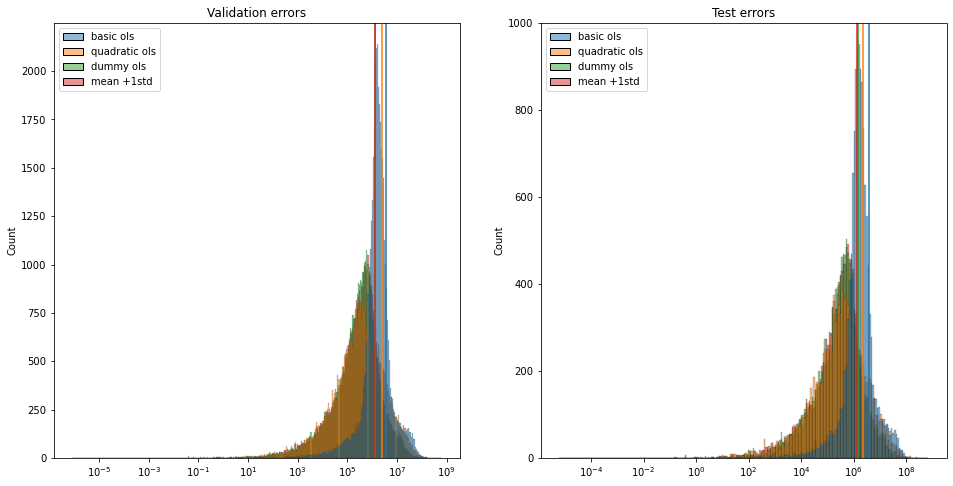

In [24]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['dummy ols'], tt_errors['dummy ols'] = get_errors(df_dummies, pipe, X, y)
sns.histplot(cv_errors, log_scale=True, ax=ax[0]).set_title('Validation errors')
sns.histplot(tt_errors, log_scale=True, ax=ax[1]).set_title('Test errors')

for pos, col in enumerate(cv_errors.columns):
    ax[0].axvline(x=cv_errors[col].mean(), c=f'C{pos}')

for pos, col in enumerate(tt_errors.columns):
    ax[1].axvline(x=tt_errors[col].mean(), c=f'C{pos}')

In [19]:
## As per Sadrach, price + 1 std: price ~ b0 + b1*carat + b2*carat^2 + b3*VVS1 + ... + e

df_dummies_trim = df_dummies[df_dummies.price <= df_dummies.price.mean() + df_dummies.price.std()]

y = ['price']
X = [col for col in df_dummies_trim.columns if col != y[0]]

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=False))
])

cross_validate(data=df_dummies_trim, endog=y, exog=X, model=pipe)

Cross-validation results: mse = 294100.37, stdev_err = 975993.89


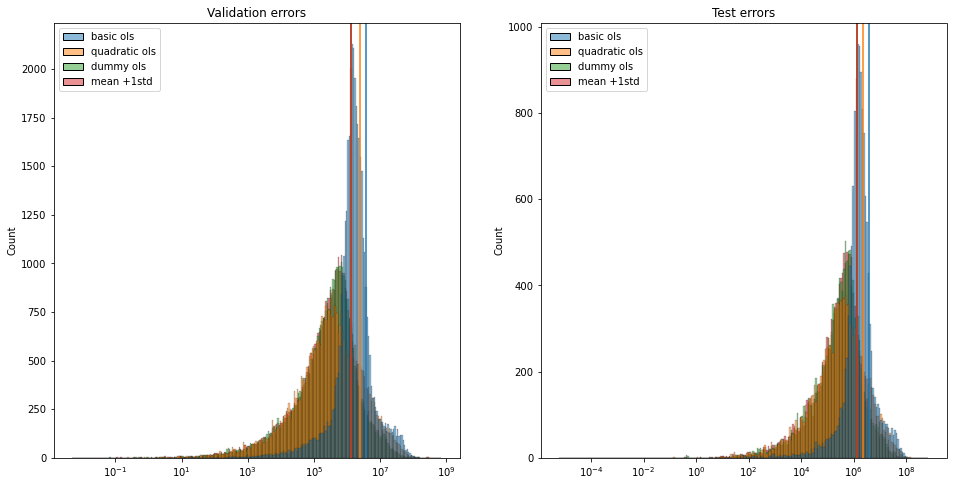

In [20]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['mean +1std'], tt_errors['mean +1std'] = get_errors(df_dummies, pipe, X, y)
sns.histplot(cv_errors, log_scale=True, ax=ax[0]).set_title('Validation errors')
sns.histplot(tt_errors, log_scale=True, ax=ax[1]).set_title('Test errors')

for pos, col in enumerate(cv_errors.columns):
    ax[0].axvline(x=cv_errors[col].mean(), c=f'C{pos}')

for pos, col in enumerate(tt_errors.columns):
    ax[1].axvline(x=tt_errors[col].mean(), c=f'C{pos}')

In [21]:
x, y = tt_tr_split(df_dummies)

In [22]:
y['pred'] = pipe.predict(y[X])